In [29]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
WANDB_NOTEBOOK_NAME = "assignment1.ipynb"
wandb.init(project="A1")

In [30]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset
    
    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})
    
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

acc,▁▁▆▆▆███
loss,█▃▄▃▁▁▁▁
acc,0.89094
loss,0.06031


In [31]:
from keras.datasets import fashion_mnist

In [32]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [33]:
y_train.shape

(60000,)

In [34]:
yt = set(y_train)
uni = list(yt)
uni

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

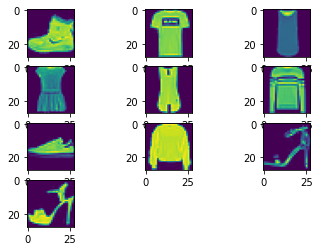

In [35]:
for i  in range(10):
    for j in y_train:
        if j == i:
            plt.subplot(4, 3, i+1)
            plt.imshow(X_train[i])
            break
            

In [36]:
X_train = X_train.reshape(X_train.shape[0], -1)/255
input_dim = 784
output_dim = 10
hidden_layers = 2
hl = [10, 10]
W = [0]*(hidden_layers+1)
b = [0]*(hidden_layers+1)
X_train.shape

(60000, 784)

In [37]:
W[0] = np.random.randn(input_dim, hl[0])
b[0] = np.zeros((1, hl[0]))

In [38]:
W[-1] = np.random.randn(hl[-1], output_dim)
b[-1] = np.zeros((1, output_dim))

In [39]:
for i in range(hidden_layers - 1):
    W[i+1] = np.random.randn(hl[i], hl[i+1])
    b[i+1] = np.zeros((1, hl[i+1]))

In [40]:
def relu(x):
    return(np.maximum(0,x))

In [53]:
z = [0]*(hidden_layers + 1)
a = [0]*(hidden_layers + 1)

In [54]:
z[0] = X_train.dot(W[0]) + b[0]
a[0] = relu(z[0])

In [55]:
for i in range(1,hidden_layers + 1):
    z[i] = a[i-1].dot(W[i]) + b[i]
    a[i] = relu(z[i])

In [56]:
z[-1] = a[-1].dot(W[-1]) + b[-1]
op = np.exp(z[-1]) / np.sum(np.exp(z[-1]), axis=1, keepdims=True)

C:\Users\jenil\AppData\Local\Temp/ipykernel_23728/2911009746.py:2: RuntimeWarning: overflow encountered in exp
  op = np.exp(z[-1]) / np.sum(np.exp(z[-1]), axis=1, keepdims=True)
C:\Users\jenil\AppData\Local\Temp/ipykernel_23728/2911009746.py:2: RuntimeWarning: invalid value encountered in true_divide
  op = np.exp(z[-1]) / np.sum(np.exp(z[-1]), axis=1, keepdims=True)


In [57]:
x = op[:][0]
np.sum(x)

1.0

In [72]:
y_test
op.shape

(60000, 10)

In [61]:
def error_a_L(yhat,y):
    er_a_L = []
    for i in range(10):
        if i == y:
            er_a_L.append(-(1-yhat[i]))
        else:
            er_a_L.append(yhat[i])
    return er_a_L

In [62]:
def L_W_k(L_a_k,h_k-1):
    return(L_a_k*h_k-1)

In [64]:
def L_b_k(L_a_k):
    return L_a_k

In [65]:
def L_h_k(W_k,L_a_k):
    return(W_k*L_a_k)

In [70]:
def a_L_k(L_h_k,deriv_g_k):
    dot = []
    for i in range(len(L_h_k)):
        dot.append(L_h_k[i]*deriv_g_k[i])
    return dot


In [71]:
def relu_deriv(x):
    data = [1 if value>0 else 0 for value in x]
    return np.array(data, dtype=float)

In [ ]:
for k in range(L,1,-1):
    der_a_L = error_a_L()

In [ ]:
class Layer:
    def __init__(self, num_inputs, num_neurons, activation, weight_init):
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.activation_fn = activation
        self.weight_init = weight_init

        self.weights = np.random.randn(self.num_inputs,self.num_neurons)
        self.biases = np.random.randn(self.num_neurons)

    def activation(self,x):
        if self.activation_fn == 'ReLU':
            return np.maximum(0,x)
        if self.activation_fn == 'softmax':
            return(np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True))

    def forward(self, cur_input):
        a = np.dot(self.weights,cur_input) + self.biases
        h = self.activation(a)
        return h    

In [ ]:
class NeuralNetwork:
    def __init__(self, num_inputs, num_classes, num_hidden_layer, num_neurons, activation, weight_init):
        self.num_inputs = num_inputs
        self.num_classes = num_classes
        self.num_hidden_layer = num_hidden_layer
        self.num_neurons = num_neurons
        self.activation = activation
        self.weight_init = weight_init
        self.layers = []
        self.layers.append(Layer(num_inputs, num_neurons, activation, weight_init))
        
        self.layers.append(Layer(num_neurons, num_classes, 'softmax', weight_init))

In [ ]:
l = Layer(2,1,'ReLU','random')